# (Draft) Nansen Legacy CTD postprocessing/water mass classification

Takes an .nc file (from NMDC) and exports the same .nc file with some additional content.

- **EOS80 variables** (*TEMP_NLEG, PSAL_NLEG, PRES_NLEG*) where we have replaced all instances where QC is not "good" with nans and applied some editing.
    - *Editing currently consists of just chopping away the upper 15 m - needs to be refined..* 
- **TEOS-10 variables** (*SA_NLEG, CT_NLEG, SIGMA0_NLEG*)
- **Buoyancy frequency squared** (N2_NLEG) and pressure at midpoints where N2 is computed (*PMIN_NLEG*)
- **Water mass classification** according to Sundfjord 2020:
    - *WMASS_STR_NLEG* contains strings ("PW", "mAW", etc)
    - *WMASS_NUM_NLEG* contains numerical values for each class 
        - (1=PW, 2=wPW, 3=AW, 4=mAW, 5=IW, 6=CBSDW, 7=EBDW/CBSDW)

Handling and modification of the netCDF file done with *xarray*.

TEOS-10 conversion and N2 calculation done using *gsw*.
 
- **THIS IS ONLY A DRAFT SCRIPT TO BE USED AS A STARTING POINT FOR A DISCUSSION!!**
- Everything in here needs double checking!

In [1]:
import numpy as np # For array operations etc
import gsw # For TEOS-10 etc
import xarray as xr # For working with the nc-file
import matplotlib.pyplot as plt # For plotting
import cmocean # For nice colormaps

/home/oyvindl/anaconda3/envs/oyv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load the dataset

These are accessible through opendap on NMDC. We can therefore load the data straight from the server: 

In [2]:
src_url = ('https://opendap1.nodc.no/opendap/physics/point/cruise/nansen_legacy/'
            'NMDC_Nansen-Legacy_PR_CT_58US_2021704.nc')

In [3]:
d = xr.open_dataset(src_url)

In [4]:
# Print time of first profile and summary to figure out what cruise 
# this is (and what to call the output file in the following cell)
print(d.TIME[0].data)
print(d.summary)

2021-04-29T16:37:48.000000000
The Nansen Legacy cruise Q2 (Q2: 2nd quarter of the year) was part of the seasonal investigation of the northern Barents Sea and adjacent Arctic Basin. The cruise was conducted during the spring period – a biologically critical time window when a large part of the annual primary production occurs – and focused on comparing the physical, chemical and biological conditions along the Nansen Legacy main transect in open waters and within the sea ice. The cruise addressed objectives of the work packages ‘Physical drivers’ (Research Focus 1), ‘Human impact’ (Research Focus 2), ‘The living Barents Sea’ (Research Focus 3) and ‘Technology and method development’ (Research Activity C).


In [5]:
### NOTE: MAKE SURE THIS IS RIGHT before producing the output file! ####

outfile_name = 'CTDs_NLEG_Q2_2021.nc'
outfile_loc = '/home/oyvindl/work/projects/water_mass_nleg/ctd_data/NLEG/'

## Making new T, S, P profiles where flags have been applied 

- NaNing out ANY data point that is no classified as "good data" (QCflag != 1)
- Using the suffix "*_NLEG*" for any new fields created by us

##### A quick look at the flags
Where are the flags? What is the range of the data?

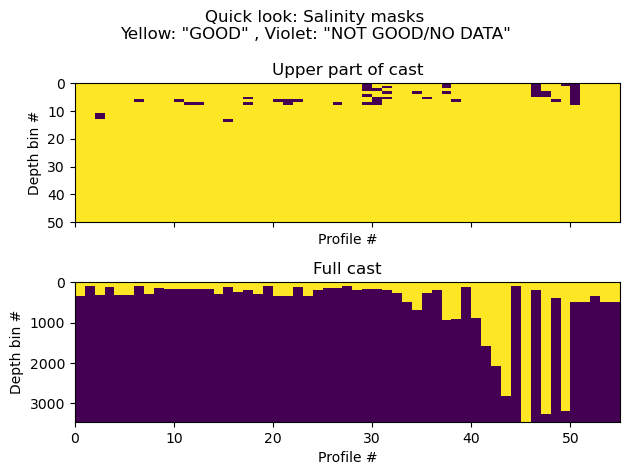

In [6]:
plot_good_PSAL = True # Quick plot of the flag

if plot_good_PSAL:
    fig, ax = plt.subplots(2,1, sharex = True)
    ax[0].pcolormesh(d['PSAL_QC'].T==1)
    ax[1].pcolormesh(d['PSAL_QC'].T==1)
    ax[0].set_ylim(50, 0)
    #ax[1].set_ylim(50, None)
    ax[1].invert_yaxis()
    for axn in ax:
        axn.set_ylabel('Depth bin #')
        axn.set_xlabel('Profile #')
    ax[0].set_title('Upper part of cast')
    ax[1].set_title('Full cast')
    fig.suptitle('Quick look: Salinity masks\nYellow: "GOOD" , Violet: "NOT GOOD/NO DATA"')
    plt.tight_layout()

## Applying flag -> NaN

Creating **new *_NLEG* variables** where we only include points with QCflag = 1/"Good"

In [7]:
d['PSAL_NLEG'] = d.PSAL.where(d.PSAL_QC==1)
d['TEMP_NLEG'] = d.TEMP.where(d.TEMP_QC==1)
d['PRES_NLEG'] = d.PRES.where(d.PRES_QC==1)

### Basic  editing
Some basic despiking/cleaning - we need to discuss how to do this, consider this a placeholder..

May want to do running filters or similar. Could consider doing some manual editing (NaNing) of obvious stuff like
the salinity blob in this dataset.

Currently, the approach is:

- **Removing *everything* above 15 db** (looks messy in ways that I think are suspicious - but I haven't looked very closely)

In [8]:
# Removing eveything above 15 db
d['PSAL_NLEG'] = d.PSAL_NLEG.where(d.PRES_NLEG>15)
d['TEMP_NLEG'] = d.TEMP_NLEG.where(d.PRES_NLEG>15)

In [9]:
# Add metadata attributes to these new variables

eos80_proc_flags_1 = ('NLEG post-processing: \nApplied all quality flags (set '
                     'all instances where [QC flag != 0] to NaN).')
eos80_proc_flags_2 = '\nChopped away all measurements above 15 m.'

d.TEMP_NLEG.attrs = {'standard_name': 'sea_water_temperature',
 'long_name': 'Sea temperature',
 'units': 'degrees_C',
 'note': eos80_proc_flags_1 + eos80_proc_flags_2}
d.PSAL_NLEG.attrs = {'standard_name': 'sea_water_practical_salinity',
 'long_name': 'Practical salinity',
 'units': '0.001',
 'note': eos80_proc_flags_1 + eos80_proc_flags_2}
d.PRES_NLEG.attrs = {'standard_name': 'sea_water_pressure',
 'long_name': 'Sea pressure',
 'units': 'dbar',
 'note': eos80_proc_flags_1}

# Computing gsw variables

Computing *SA, CT, sig0, N2*

Using the default gsw algorithm -> includes the dSA coefficient from the dSA "atlas"

If we want to have N2 included, we should consider pre-smoothing the profiles.

In [10]:
# Compute Absolute Salinity

SA = gsw.SA_from_SP(d.PSAL_NLEG.data, d.PRES_NLEG.data, 
                    d.LONGITUDE.data[:, np.newaxis], d.LATITUDE.data[:, np.newaxis])
d['SA_NLEG'] = (('TIME', 'DEPTH'), SA)

In [11]:
# Compute Conservative Temperature

CT = gsw.CT_from_t(SA, d.TEMP_NLEG.data, d.PRES_NLEG.data)
d['CT_NLEG'] = (('TIME', 'DEPTH'), CT)

In [12]:
# Compute Sigma0 density

sig0 = gsw.sigma0(SA, CT)
d['SIG0_NLEG'] = (('TIME', 'DEPTH'), sig0)

In [13]:
# Compute N2 at mid-pressure (note: this just applying the GSW algorithm. It  is sensitive to
# outliers - we may want to think about whether/how to do this.)

N2, P_mid = gsw.Nsquared(SA, CT, d.PRES_NLEG.data, d.LATITUDE.data[:, np.newaxis], axis = 1)
d.expand_dims({'DEPTH_MID':d.dims['DEPTH']-1})
d['PRES_MID_NLEG'] = (('TIME', 'DEPTH_MID'), P_mid)
d['N2_NLEG'] = (('TIME', 'DEPTH_MID'), N2)

In [14]:
# Add metadata attributes to the ncfile

d.SA_NLEG.attrs = {'standard_name': 'sea_water_absolute_salinity',
 'long_name': 'Absolute Salinity', 'units': 'g kg-1',
 'note': ('Absolute Salinity calculated from (PSAL_NLEG, PRES_NLEG, LONGITUDE, LATITUDE) using'
          ' the *gsw* module (https://teos-10.github.io/GSW-Python/. The dSA coefficient was '
          'taken from the gsw-atlas.')}
d.CT_NLEG.attrs = {'standard_name': 'sea_water_conservative_temperature',
 'long_name': 'Conservative Temperature', 'units': 'degrees_C',
 'note': ('Conservative Temperature calculated from (SA_NLEG, TEMP_NLEG, PRES_NLEG) using'
          ' the *gsw* module (https://teos-10.github.io/GSW-Python/.')}
d.SIG0_NLEG.attrs = {'standard_name': 'sea_water_sigma_t',
 'long_name': 'Potential density anomaly with reference pressure of 0 dbar'
 'this being this particular potential density minus 1000 kg/m^3.', 'units': 'kg m-3',
 'note': ('Potential density anomaly sigma0 calculated from (SA_NLEG, CT_NLEG) using'
          ' the *gsw* module (https://teos-10.github.io/GSW-Python/.')}
d.N2_NLEG.attrs = {'standard_name': 'square_of_brunt_vaisala_frequency_in_sea_water',
 'long_name': 'Buoyancy frequency squared', 'units': 's-2',
 'note': ('Buoyancy frequency squared calculated from (SA_NLEG, CT_NLEG, PRES_NLEG LONGITUDE,'
          'LATITUDE) using the *gsw* module (https://teos-10.github.io/GSW-Python/.\n'
          'Vertical (pressure) grid: PRES_MID_NLEG'
          'Note: Calculated from unsmoothed profiles; very sensitive to noise. USE WITH CAUTION!')}
d.PRES_MID_NLEG.attrs = {'standard_name': 'sea_water_pressure',
 'long_name': 'Sea pressure', 'units': 'dbar',
 'note': ('Ocean pressure at mid-values where N2_NLEG is computed.')}

# Water mass classification

### Define a water mass classifier function 

In [15]:
def classify(SA, CT, sig0):
    '''
    Reads (single) values of SA, CT, and sig0 and classifies the mesurements in the
    water mass space from Sundfjord et al 2020
    '''
    if (CT<=0) and (sig0<=27.97):
        wm, wmnum= 'PW', 1
    elif (CT>0) and (SA<35.06):
        wm, wmnum = 'wPW', 2   
    elif (CT>2) and (SA>=35.06):
        wm, wmnum = 'AW', 3  
    elif (CT<=2) and (CT>0 and SA>=35.06):
        wm, wmnum = 'mAW', 4  
    elif (CT>-1.1) and (CT<=0 and sig0>27.97):
        wm, wmnum = 'IW', 5  
    elif (CT<=-1.1) and (sig0>27.97):
        wm, wmnum = 'CBDSW', 6
        if (SA>=35.06):
            wm, wmnum = 'EBDW/CBSDW', 7  
    try:
        return wm, wmnum
    except:
        raise Exception('Something went wrong. These were the inputs:'
                        '\nSA= %s\nCT=%f\nsig0= %f'%(SA, CT, sig0))

In [16]:
# Quick test with an arbitrary sample

nn, mm = 30, 30 # Pick out index [nn, mm]
SA_, CT_, sig0_ = SA[nn, mm], CT[nn, mm], sig0[nn, mm]

print('Inputs:\nSA: %s\nCT: %f\nsig0: %f'%(SA_, CT_, sig0_))

wm, wmnum = classify(SA_, CT_, sig0_)
print('\nOutputs:\n-> Water mass classification: %s'%(wm))
print('-> Water mass numerical value: %i'%(wmnum))

Inputs:
SA: 34.59365806659633
CT: -1.819247
sig0: 27.721534

Outputs:
-> Water mass classification: PW
-> Water mass numerical value: 1


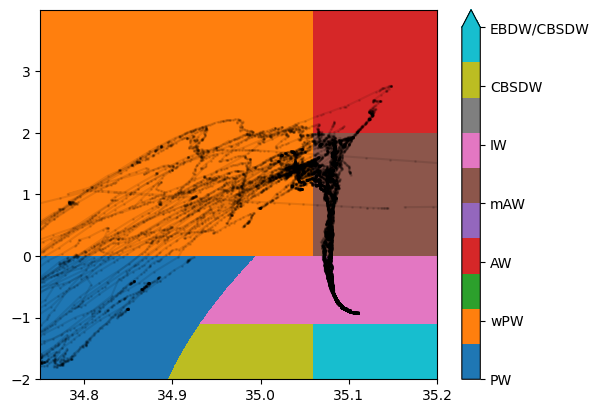

In [17]:
# Option:
# Take a quick look at the water mass distribution as defined by 
# the classify() function in SA-CT space

quicklook_classifier = True

if quicklook_classifier:
    SAarr = np.arange(34.75, 35.2, 0.0005)
    CTarr = np.arange(-2, 4, 0.001)
    SA, CT = np.meshgrid(SAarr, CTarr)
    sig0 = gsw.sigma0(SA, CT)

    WMNUM = SA*np.nan
    for nn in np.arange(WMNUM.shape[0]):
        for mm in np.arange(WMNUM.shape[1]):
            wm, WMNUM[nn, mm] = classify(SA[nn, mm], CT[nn, mm], sig0[nn, mm])
            
    # Plot the water mass space (and show the CTD data)

    fig, ax = plt.subplots()
    C = ax.pcolormesh(SAarr, CTarr, WMNUM, cmap = 'tab10', vmin = 1, vmax = 7)
    cb = plt.colorbar(C, extend = 'max', ax = ax, 
                     orientation = 'vertical')
    cb.ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
    cb.ax.set_yticklabels(['PW', 'wPW', 'AW', 'mAW', 'IW', 'CBSDW', 'EBDW/CBSDW']);
    
    ax.plot(d.SA_NLEG, d.CT_NLEG, '.k', ms = 2, alpha = 0.1)
    ax.plot(d.SA_NLEG.T, d.CT_NLEG.T, '-k', ms = 2, alpha = 0.1)

    ax.set_xlim(SAarr.min(), SAarr.max())

Pleasant swirly shape!

.. but there is definitely some need for salinity cleaning!

### Apply to the CTD dataset

Apply the classification to the CTD data and store the results as the variables *WMASS_STR_NLEG*, *WMASS_NUM_NLEG*

In [18]:
CTD_WMS_num = np.nan*np.ones([d.dims['TIME'], d.dims['DEPTH']])
CTD_WMS_str = (np.nan*np.ones([d.dims['TIME'], d.dims['DEPTH']])).tolist()

# Loop through each sample
for nn in np.arange(d.dims['TIME']):
    for mm in np.arange(d.dims['DEPTH']):
        SA_, CT_, sig0_ =  d.SA_NLEG.data[nn, mm], d.CT_NLEG.data[nn, mm], d.SIG0_NLEG.data[nn, mm]
        if not np.isnan([SA_, CT_]).any():
            CTD_WMS_str[nn][mm], CTD_WMS_num[nn, mm] = classify(SA_, CT_, sig0_)
        else:
            CTD_WMS_str[nn][mm] = ''

d['WMASS_STR_NLEG'] = (('TIME', 'DEPTH'), CTD_WMS_str)
d['WMASS_NUM_NLEG'] = (('TIME', 'DEPTH'), CTD_WMS_num)

In [19]:
# ADD METADATA ATTRIBUTES TO THE WATER MASS VARIABLES

# A general cautionary note to be applied to the water mass fields..
user_wm_warning = ('\n**PROCEED WITH CAUTION**: Water mass analysis in T-S space is a useful '
       'tool, but any classification scheme is a rough and somewhat subjective approximation.'
       ' The Sundfjord 2020 framework is one compromise that will do a good job in some cases and'
       " less so in others.\n\n-> Remember to *look at your data*, and don't blindly rely on"
        ' water mass classifactions!')

# A note about the "EBDW/CBSDW" class
ebdw_cbdsw_note = ('Needs other contextual information to differentiate between EBDW and CBDSW. '
    'From Sundfjord et al. (2020): \n\n'
    'Eurasian Basin Deep Water (EBDW) can be used for waters beyond the 500 m isobath over the'
                   ' continental slope North of the Barents Sea.')

d.WMASS_STR_NLEG.attrs = {
 'long_name': 'Water mass classification (STRING)',
 'reference': ('Sundfjord et al. (2020): Suggested water mass definitions'
    ' for the central and northern Barents Sea, and the adjacent Nansen '
    'Basin: Workshop Report'),
 'reference_doi': 'https://doi.org/10.7557/nlrs.5707 ',
 'description': ('Water mass classification based on (SA_NLEG, CT_NLEG, SIGMA0_NLEG). Water'
                 ' masses (TEOS-10) from Sundfjord et al (2020). '
                '\nString values ("AW", "wPW", etc..)'),
 'ebdw_cbdsw_note': ebdw_cbdsw_note,
 'note_to_users': user_wm_warning}

d.WMASS_NUM_NLEG.attrs = {
 'long_name': 'Water mass classification (INTEGER)',
 'reference': ('Sundfjord et al. (2020): Suggested water mass definitions'
    ' for the central and northern Barents Sea, and the adjacent Nansen '
    'Basin: Workshop Report'),
 'reference_doi': 'https://doi.org/10.7557/nlrs.5707',
 'description': ('Water mass classification based on (SA_NLEG, CT_NLEG, SIGMA0_NLEG). Water'
                 ' masses (TEOS-10) from Sundfjord et al (2020). '
                'The water masses corresponding to each integer value can be found in '
                 '*wm_integer_key*'),
 'wm_integer_key': ('1=PW, 2=wPW, 3=AW, 4=mAW, 5=IW, 6=CBSDW, 7=EBDW/CBSDW*\n'
    '*see ebdw_cbdsw_note'),
 'ebdw_cbdsw_note': ebdw_cbdsw_note,
 'note_to_users': user_wm_warning}

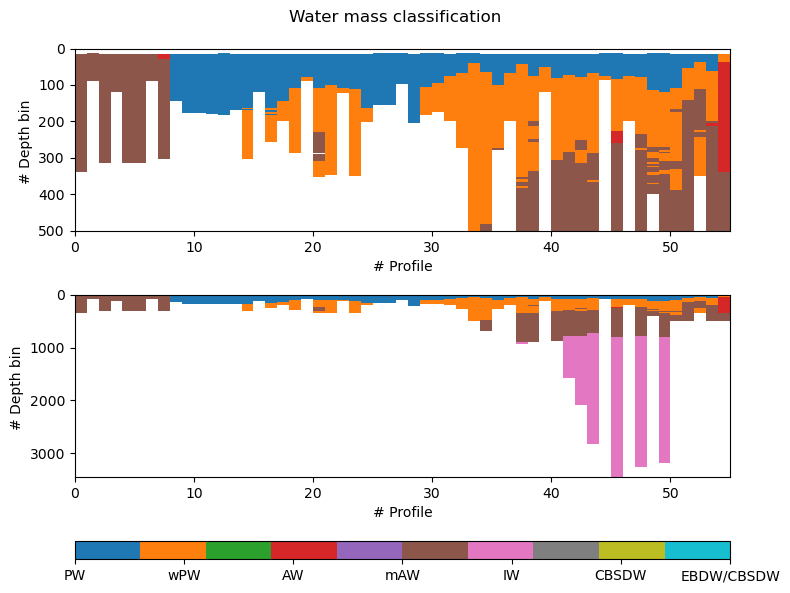

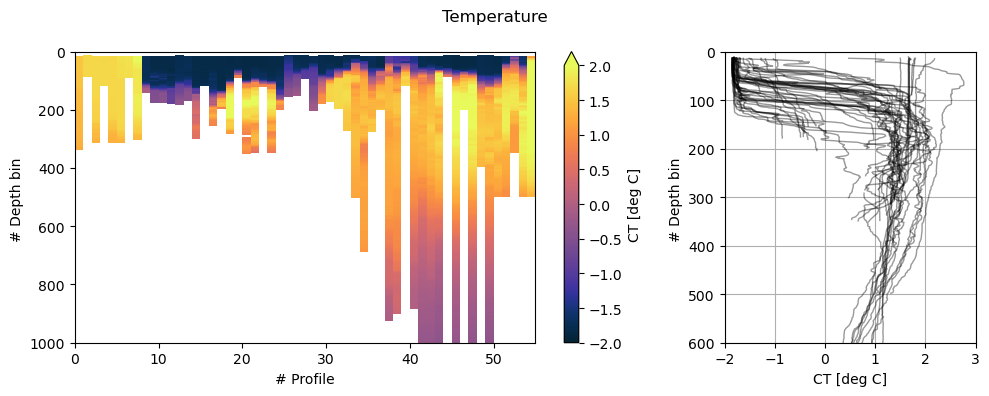

In [20]:
# Optional: Quick plot of the resulting classification

show_ctd_classification = True

if show_ctd_classification:
    fig = plt.figure(figsize = (8, 6))
    ax0 = plt.subplot2grid((7, 1), (0, 0), rowspan = 3)
    ax1 = plt.subplot2grid((7, 1), (3, 0), rowspan = 3)
    cax = plt.subplot2grid((7, 1), (6, 0), rowspan = 1)

    ax0.pcolormesh(d['WMASS_NUM_NLEG'].T, cmap = 'tab10', vmin = 1, vmax = 7)
    ax0.set_ylim(500, 0)
    C = ax1.pcolormesh(d['WMASS_NUM_NLEG'].T, cmap = 'tab10', vmin = 1, vmax = 7)
    ax1.invert_yaxis()
    cb = plt.colorbar(C, ticks = [0, 1, 2, 3, 4, 5, 6, 7], cax = cax, 
                     orientation = 'horizontal')
    cax.set_xticks([1, 2, 3, 4, 5, 6, 7])
    cax.set_xticklabels(['PW', 'wPW', 'AW', 'mAW', 'IW', 'CBSDW', 'EBDW/CBSDW'])
    for axn in [ax0, ax1]:
        axn.set_ylabel('# Depth bin ')
        axn.set_xlabel('# Profile');
        fig.suptitle('Water mass classification')
    plt.tight_layout()
    
# Option: Look at hte temperature (was there really almost no AW?)

show_ctd_temp = True

if show_ctd_temp:
    fig = plt.figure(figsize = (10, 4))
    ax0 = plt.subplot2grid((1, 3), (0, 0), colspan = 2)
    ax1 = plt.subplot2grid((1, 3), (0, 2), colspan = 1)

    C = ax0.pcolormesh(d['CT_NLEG'].T, cmap = cmocean.cm.thermal, 
                      vmin = -2, vmax = 2)
    ax0.invert_yaxis()
    cb = plt.colorbar(C, extend = 'max', label = 'CT [deg C]', ax = ax0, 
                     orientation = 'vertical')

    ax0.set_ylabel('# Depth bin ')
    ax0.set_xlabel('# Profile');
    ax0.set_ylim(1000, 0)

    ax1.plot(d['CT_NLEG'].T, np.arange(d.dims['DEPTH']), color = 'k', 
             alpha = 0.4, lw = 1)
    ax1.set_ylim(600, 0)
    ax1.set_xlim(-2, 3)

    ax1.grid()
    ax1.set_ylabel('# Depth bin ')
    ax1.set_xlabel('CT [deg C]');
    fig.suptitle('Temperature')

    plt.tight_layout()

#### Add some general metadata attributes to the ncfile

In [21]:
d.attrs['contact'] = (d.attrs['contact'] + 
    ' (for _NLEG variables and water masses: see "NLEG_contact")')
d.attrs['references'] = (d.attrs['references'] + 
    ', Sundfjord et al (2020): https://doi.org/10.7557/nlrs.5707')
d.attrs['NLEG_contact'] = ('Arild Sundfjord: arild.sundfjord@npolar.no\n'
                           'Karen Assmann: karen.assmann@hi.no\n'
                           'Øyvind Lundesgaard: oyvind.lundesgaard@npolar.no\n'
                           'Angelika H.H. Renner: angelika.renner@hi.no\n'
                           'Randi Ingvaldsen: randi.ingvaldsen@hi.no')
d.attrs['history'] = ('"_NLEG" variables and water mass classifications were appended to the file'
                     ' by Nansen Legacy water mass working group (see "NLEG_contact"). '
                     'More information in the attributes of individual "_NLEG" variables.')
d.attrs['summary'] = (d.attrs['summary'] +'\n\n'+ d.attrs['history'])

# Save

In [22]:
# Have to do this little tweak in order to be able to save later on
# (see https://github.com/pydata/xarray/issues/2822)
del d.attrs['_NCProperties']

In [23]:
d.to_netcdf(outfile_loc + outfile_name, mode ='w')
print('Saved to %s'%(outfile_loc + outfile_name))

Saved to /home/oyvindl/work/projects/water_mass_nleg/ctd_data/NLEG/CTDs_NLEG_Q2_2021.nc


### Quick inspection of metadata

In [24]:
# Look at the SA_NLEG variable 
d.SA_NLEG

<xarray.DataArray 'SA_NLEG' (TIME: 55, DEPTH: 3452)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2021-04-29T16:37:48 ... 2021-05-18T13:43:13
Dimensions without coordinates: DEPTH
Attributes:
    standard_name:  sea_water_absolute_salinity
    long_name:      Absolute Salinity
    units:          g kg-1
    note:           Absolute Salinity calculated from (PSAL_NLEG, PRES_NLEG, ...

In [25]:
# Look at the SA_NLEG variable 
d.WMASS_NUM_NLEG

<xarray.DataArray 'WMASS_NUM_NLEG' (TIME: 55, DEPTH: 3452)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2021-04-29T16:37:48 ... 2021-05-18T13:43:13
Dimensions without coordinates: DEPTH
Attributes:
    long_name:        Water mass classification (INTEGER)
    reference:        Sundfjord et al. (2020): Suggested water mass definitio...
    reference_doi:    https://doi.org/10.7557/nlrs.5707
    description:      Water mass classification based on (SA_NLEG, CT_NLEG, S...
    wm_integer_key:   1=PW, 2=wPW, 3=AW, 4=mAW, 5=IW, 6=CBSDW, 7=EBDW/CBSDW*\...
    ebdw_cbdsw_note:  Needs other contextual information to differentiate bet...
    note_to_users:    \n**PROCEED WITH CAUTION**: Water mass analysis in T-S ...

In [26]:
# Look at the whole file (variables and attributes)
d

<xarray.Dataset>
Dimensions:         (TIME: 55, LATITUDE: 55, LONGITUDE: 55, POSITION: 55, DEPTH: 3452, DEPTH_MID: 3451)
Coordinates:
  * TIME            (TIME) datetime64[ns] 2021-04-29T16:37:48 ... 2021-05-18T...
  * LATITUDE        (LATITUDE) float32 75.68 76.0 76.0 ... 81.31 81.35 80.46
  * LONGITUDE       (LONGITUDE) float32 30.46 31.22 31.22 ... 22.21 16.71 12.06
Dimensions without coordinates: POSITION, DEPTH, DEPTH_MID
Data variables: (12/47)
    POSITION_QC     (POSITION) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    DIRECTION       object b'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...
    PRES            (TIME, DEPTH) float32 2.0 3.0 4.0 5.0 ... nan nan nan nan
    PRES_QC         (TIME, DEPTH) float32 1.0 1.0 1.0 1.0 ... nan nan nan nan
    TEMP            (TIME, DEPTH) float64 2.068 2.166 2.182 ... nan nan nan
    PSAL            (TIME, DEPTH) float64 34.92 34.92 34.92 ... nan nan nan
    ...              ...
    CT_NLEG         (TIME, DEPTH) float64 nan nan nan nan ... nan nan nan nan
    SIG0_NLEG       (TIME, DEPTH) float64 nan nan nan nan ... nan nan nan nan
    PRES_MID_NLEG   (TIME, DEPTH_MID) float64 2.5 3.5 4.5 5.5 ... nan nan nan
    N2_NLEG         (TIME, DEPTH_MID) float64 nan nan nan nan ... nan nan nan
    WMASS_STR_NLEG  (TIME, DEPTH) <U3 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    WMASS_NUM_NLEG  (TIME, DEPTH) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/67)
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        datahjelp@hi.no (for _NLEG variables and ...
    distribution_statement:         These data are public and free of charge....
    naming_authority:               Norwegian Marine Datacenter
    license:                        https://creativecommons.org/licenses/by/4...
    data_assembly_center:           IMR
    ...                             ...
    creator_type:                   person
    creator_email:                  martin.ludvigsen@unis.no
    creator_url:                    https://www.unis.no/
    publisher:                      The Norwegian Marine Data Centre (NMD)
    publisher_url:                  https://www.nmdc.no/
    NLEG_contact:                   Arild Sundfjord: arild.sundfjord@npolar.n...